In [1]:
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd
from scipy.linalg import pinv
from itertools import product
import numpy as np, h5py, os
import matplotlib.pyplot as plt
from operator import itemgetter 
from scipy.sparse import vstack, coo_matrix, csc_matrix, isspmatrix_csc
%matplotlib inline
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



In [2]:
genes = pd.read_csv("genes.csv")["gene"].to_numpy()

foreground_cells = pd.read_csv("foreground_cells.csv")["cell"].to_numpy()

foreground = pd.read_csv("foreground_matrix.csv", index_col=0)
X = foreground.to_numpy()

background = pd.read_csv("background_matrix.csv")
Y = background.to_numpy()


In [3]:
from main import*

In [4]:
cols_contrastive, rows_contrastive, hist = iccur(
       X, Y, cols=10, rows=25, k=7,
       max_iter=100, epsilon=1e-6,
       theta_S=0.90, theta_T=0.90, patience=2,
       verbose=True
 )
genes[cols_contrastive]

array(['B3galt5', 'Clu', 'Hspa1a', 'Lrg1', 'Pla2g4c', 'Retnlb', 'Saa1',
       'Sptssb', 'Tyrobp', 'Wfdc18'], dtype=object)

In [5]:

r =50
k=7
rows_foreground = deterministic_cur(X,k, r)[4]


In [6]:
import seaborn as sns
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

/nas/longleaf/home/eyzhang/.local/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:586: UserWarning: You’re trying to run this on 1000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


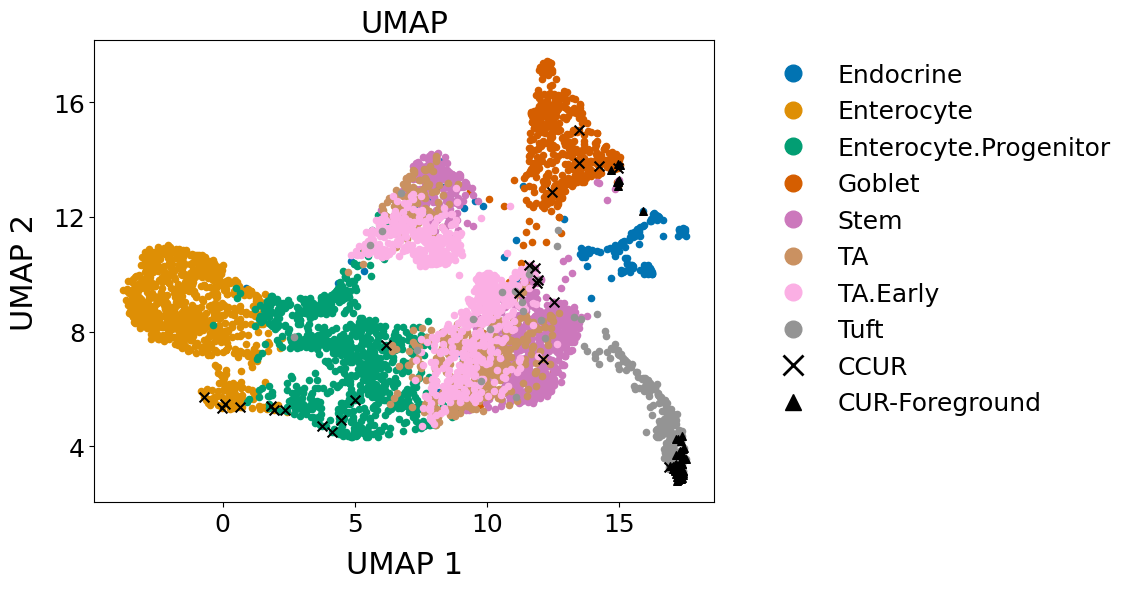

In [7]:
adata = sc.AnnData(foreground.values)
adata.obs['barcode'] = foreground.index
adata.var['gene_name'] = foreground.columns

adata.obs['cell_type'] = adata.obs['barcode'].apply(lambda x: x.split('_')[-1])

sc.pp.neighbors(adata, n_neighbors=30)
sc.tl.umap(adata)

contrastive_indices = adata.obs.index[adata.obs['barcode'].isin(foreground_cells[T])].tolist()
foreground_indices = adata.obs.index[adata.obs['barcode'].isin(foreground_cells[rows_foreground])].tolist()
contrastive_indices = [int(i) for i in contrastive_indices]
foreground_indices = [int(i) for i in foreground_indices]

coords = adata.obsm['X_umap']

unique_cell_types = sorted(adata.obs['cell_type'].unique())

palette = dict(zip(unique_cell_types, sns.color_palette("colorblind", len(unique_cell_types))))

plt.figure(figsize=(8, 6))

for cell_type in unique_cell_types:
    cell_type_indices = adata.obs.index[adata.obs['cell_type'] == cell_type]
    cell_type_coords = coords[[int(idx) for idx in cell_type_indices], :]
    plt.scatter(
        cell_type_coords[:, 0],
        cell_type_coords[:, 1],
        color=palette[cell_type],
        s=20,
        alpha=1,
        label=cell_type
    )

plt.scatter(
    coords[T, 0],
    coords[T, 1],
    color='black',
    marker='x',
    s=50,
    label='CCUR'
)

plt.scatter(
    coords[foreground_indices, 0],
    coords[foreground_indices, 1],
    color='black',
    edgecolor='black',  
    marker='^',
    s=30,
    label='CUR-Foreground'
)

plt.title("UMAP", fontsize=22)
plt.xlabel("UMAP 1", fontsize=22, labelpad=10)
plt.ylabel("UMAP 2", fontsize=22, labelpad=10)

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))  
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

handles, labels = [], []
for cell_type in unique_cell_types:
    handles.append(plt.Line2D([0], [0], marker='o', color=palette[cell_type], markersize=12, linestyle='None'))
    labels.append(cell_type)

handles.append(plt.Line2D([0], [0], marker='x', color='black', markersize=14, markeredgewidth = 2,linestyle='None', label='CCUR'))
labels.append('CCUR')
handles.append(plt.Line2D([0], [0], marker='^', color='black', markersize=12, linestyle='None', label='CUR-Foreground'))
labels.append('CUR-Foreground')

plt.legend(
    handles=handles,
    labels=labels,
    title="",
    title_fontsize=14,
    fontsize=18,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=False
)

os.chdir('/nas/longleaf/home/eyzhang/ccur/Pathogen')
plt.savefig('pathogen_rows.png', dpi=300, bbox_inches='tight')
plt.show()


In [8]:
adata.obs['int_index'] = adata.obs.index.astype(int)

index_to_cell_type = adata.obs.set_index('int_index')['cell_type']

results = {}

methods = {
    'CCUR': T,
    'CUR': rows_foreground,
}

for method_name, indices in methods.items():
    indices = [int(i) for i in indices]
    
    selected_cell_types = index_to_cell_type.loc[indices]
    counts = selected_cell_types.value_counts()
    
    proportions = counts / counts.sum()
    
    results[method_name] = proportions

total_cell_counts = adata.obs['cell_type'].value_counts()
total_proportions = total_cell_counts / total_cell_counts.sum()

results_df = pd.DataFrame(results).fillna(0)

results_df['True_Proportion'] = total_proportions


print(results_df)


                       CCUR   CUR  True_Proportion
cell_type                                         
Endocrine              0.00  0.02         0.033698
Enterocyte             0.24  0.00         0.185896
Enterocyte.Progenitor  0.24  0.00         0.181879
Goblet                 0.20  0.12         0.098862
Stem                   0.12  0.04         0.178308
TA                     0.08  0.00         0.103771
TA.Early               0.04  0.00         0.164249
Tuft                   0.08  0.82         0.053336
